# Scratchpad - Dallas Morning News Case Study

The Dallas Morning News [uncovers a cheating scandal on the TAKS test](http://clipfile.org/?p=754). 

_note: Try not to consult the clip above unless you're stuck. The clip also doesn't contain all of the answers so there is still plenty to investigate._

You're a reporter at the Dallas Morning News in 2005. While talking to some teachers at your local school district, you recieved a tip that a fourth grade classroom at Harrell Budd Elementary in southern Dallas has unusually high test scores in reading on the TAKS test (the state's standardized test to measure student progress). To check out this claim you've downloaded data from the Texas Education Agency. To dig deeper into this, you have acquired records from the district of average standardized TAKS test scores for reading and math for third, fourth and fifth graders for the previous year. You also decide to download the reading scores for 2003.

Let's see how the Dallas Morning News used regressions to find evidence of this claim and try to find out if it is an isolated case.

### R and Python imports

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
%%R

require('tidyverse')

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **cfy04e4.dat:** 2004 fourth-grade TAKS scores - standardized test scores for 2004's fourth-graders
* **cfy04e5.dat:** 2004 fifth-grade TAKS scores - standardized test scores for 2004's fifth-graders
* **cfy04e3.dat:** 2004 third-grade TAKS scores - standardized test scores for 2004's third-graders

More data you might want
* **cfy03e3.dat:** 2003 third-grade TAKS scores - standardized test scores for 2003's third-graders

Data Documentation: 
https://tea.texas.gov/student-assessment/testing/taks-resources/taks-variables-formats-and-descriptions


In [ ]:
# # Make data directory if it doesn't exist
# !mkdir -p data
# !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e4.dat -P data
# !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy03e3.dat -P data
# !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e5.dat -P data
# !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e3.dat -P data

## Finding suspicious behavior by tracking down outliers

In [ ]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# Reading 2004 test scores data

We'll start by opening up our dataset - standardized test performance at each school, for third, fourth and fifth graders in 2004 in both math and reading.

In [83]:
df_third_grade_2004 = pd.read_csv("data/cfy04e3.dat", usecols=['r_all_rs', 'm_all_rs', 'CNAME', 'CAMPUS']).set_index('CAMPUS').add_suffix('_third')
df_fourth_grade_2004 = pd.read_csv("data/cfy04e4.dat", usecols=['r_all_rs', 'm_all_rs', 'CNAME', 'CAMPUS']).set_index('CAMPUS').add_suffix('_fourth')
df_fifth_grade_2004 = pd.read_csv("data/cfy04e5.dat", usecols=['r_all_rs', 'm_all_rs', 'CNAME', 'CAMPUS']).set_index('CAMPUS').add_suffix('_fifth')

# Combine the above dataframes, remove duplicate columns
df = pd.concat([df_third_grade_2004, df_fourth_grade_2004, df_fifth_grade_2004], axis=1)
df['CNAME'] = df['CNAME_third'].fillna(df['CNAME_fourth']).fillna(df['CNAME_fifth'])
df = df.drop(columns=['CNAME_third', 'CNAME_fourth', 'CNAME_fifth'])
df = df.reset_index()

# display
df


,CAMPUS,r_all_rs_third,m_all_rs_third,r_all_rs_fourth,m_all_rs_fourth,r_all_rs_fifth,m_all_rs_fifth,CNAME
0,1902103,2410.0,2388.0,2392.0,2227.0,2308.0,2317.0,CAYUGA EL
1,1903101,2256.0,2208.0,2263.0,2192.0,2193.0,2153.0,ELKHART EL
2,1904102,2284.0,2313.0,2242.0,2152.0,2288.0,2256.0,FRANKSTON EL
3,1906102,2294.0,2273.0,2218.0,2096.0,2298.0,2312.0,NECHES EL
4,1907110,2256.0,2205.0,2200.0,2168.0,2218.0,2269.0,STORY EL
...,...,...,...,...,...,...,...,...
4232,241904041,NaN,NaN,NaN,NaN,NaN,NaN,WHARTON J H
4233,243902041,NaN,NaN,NaN,NaN,2117.0,2129.0,ELECTRA J H
4234,249905102,NaN,NaN,NaN,NaN,2238.0,2255.0,DECATUR INT
4235,250907041,NaN,NaN,NaN,NaN,2231.0,2241.0,MEMORIAL MIDDLE


Here is the dataframe above in long format if you (or your plots) prefer it that way!


In [69]:
df_long = df.melt(id_vars=['CAMPUS', 'CNAME'], var_name='test_type', value_name='score').dropna()
df_long

,CAMPUS,CNAME,test_type,score
0,1902103,CAYUGA EL,r_all_rs_third,2410.0
1,1903101,ELKHART EL,r_all_rs_third,2256.0
2,1904102,FRANKSTON EL,r_all_rs_third,2284.0
3,1906102,NECHES EL,r_all_rs_third,2294.0
4,1907110,STORY EL,r_all_rs_third,2256.0
...,...,...,...,...
33464,253901101,BENAVIDES EL,m_all_rs_fourth_last_year,2189.0
33465,253901106,ZAPATA SOUTH EL,m_all_rs_fourth_last_year,2253.0
33466,253901107,ZAPATA CENTRAL,m_all_rs_fourth_last_year,2178.0
33467,254901105,LORENZO DE ZAVA,m_all_rs_fourth_last_year,2180.0


# Exploratory Data Analysis

## Descriptive Stats

In [70]:
df.describe().round(1)

,CAMPUS,r_all_rs_third,m_all_rs_third,r_all_rs_fourth,m_all_rs_fourth,r_all_rs_fifth,m_all_rs_fifth,r_all_rs_fourth_last_year,m_all_rs_fourth_last_year
count,4237.0,3745.0,3749.0,3706.0,3709.0,3453.0,3452.0,3745.0,3749.0
mean,115343592.6,2274.5,2238.9,2227.2,2217.5,2202.5,2220.4,2274.5,2238.9
std,71979517.5,63.2,74.8,68.6,78.5,89.0,98.3,63.2,74.8
min,1902103.0,1858.0,1924.0,1951.0,1898.0,1805.0,1816.0,1858.0,1924.0
25%,57909110.0,2234.0,2193.0,2181.0,2168.0,2141.0,2157.0,2234.0,2193.0
50%,101912217.0,2276.0,2239.0,2226.0,2216.0,2200.0,2216.0,2276.0,2239.0
75%,178902103.0,2318.0,2288.0,2273.0,2268.0,2260.0,2282.0,2318.0,2288.0
max,254902101.0,2503.0,2497.0,2509.0,2520.0,2476.0,2696.0,2503.0,2497.0


### Example Histograms
Exploratory Data Visualization

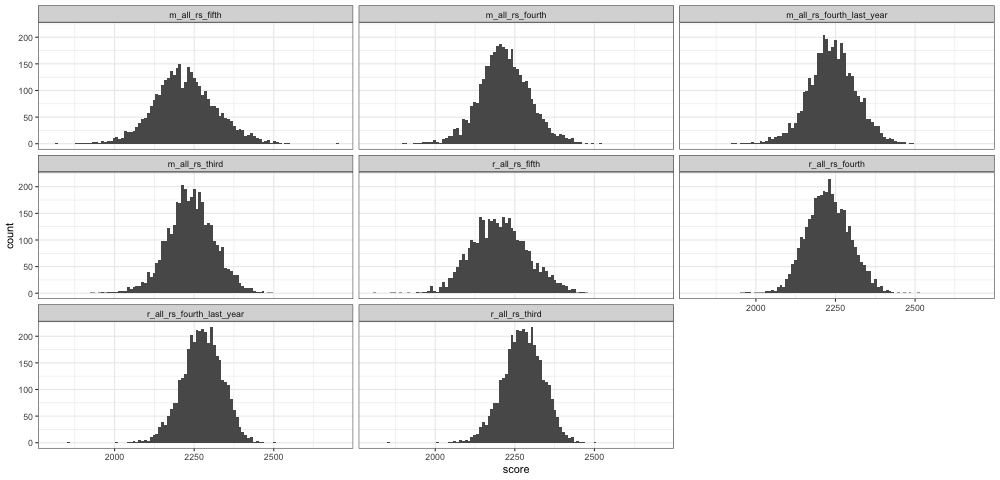

In [71]:
%%R -i df_long -w 1000

to_plot <- df_long

ggplot(to_plot, aes(x=score)) + 
    geom_histogram(bins=100)+
    facet_wrap(~test_type) +
    theme_bw()


## Example Scatter Plot
Exploratory Data Visualization (comparing 3rd vs 4th grade reading scores in 2004)

`geom_smooth()` using formula = 'y ~ x'


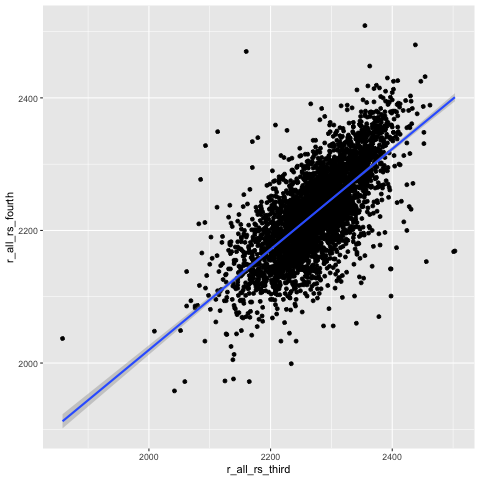

In [72]:
%%R -i df

ggplot(df) +
    aes(x=r_all_rs_third, y=r_all_rs_fourth) +
    geom_point() +
    geom_smooth(method='lm') # show linear regression line (without standard error)

## Example Regression

Using a regression to predict fourth-grade reading scores using third grade reading scores

_note: the `y~x` syntax in the command below. The left side contains the **dependent variable** (y) and the right side contains the **independent variable** (x)_

In [73]:
%%R -i df

model <- lm(r_all_rs_fourth ~ r_all_rs_third, data=df)
summary(model)


Call:
lm(formula = r_all_rs_fourth ~ r_all_rs_third, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-236.25  -30.37    1.81   31.69  328.97 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    504.01302   29.52598   17.07   <2e-16 ***
r_all_rs_third   0.75788    0.01298   58.40   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 49.19 on 3555 degrees of freedom
  (680 observations deleted due to missingness)
Multiple R-squared:  0.4896,	Adjusted R-squared:  0.4895 
F-statistic:  3410 on 1 and 3555 DF,  p-value: < 2.2e-16



#### Investigating the Residuals

Residuals are the difference between the predicted and actual values. 

![](residuals.png)

Think of them as the "error" part of the above formulation.

In [76]:
%%R -i df


to_plot <- df %>% 
    # remove nulls
    filter(!is.na(r_all_rs_fourth) & !is.na(r_all_rs_third)) %>% 
    # select only 3rd and 4th grade reading scores from 2004
    select(CAMPUS, CNAME, r_all_rs_fourth, r_all_rs_third) %>%
    # use the model we trained in the previous cell to predict scores
    #   grab the residuals, and convert them to standardized z-scores
    #   (remember, a z-score the # of stdevs above or below the mean a datapoint is)
    mutate(predicted_r_all_rs_fourth = predict(model),
          residuals = r_all_rs_fourth - predicted_r_all_rs_fourth,
          residuals_z_scores = (residuals - mean(residuals)) / sd(residuals)) %>%
    # sort from highest to lowest z score (remember, they can be negative too)
    arrange(-residuals_z_scores)

# show the first 5 rows of this data
to_plot %>% head(5)

        CAMPUS           CNAME r_all_rs_fourth r_all_rs_third
799   57905115 HARRELL BUDD EL            2470           2160
105   15803101 HIGGS/CARTER/KI            2349           2113
443   24801101   ENCINO SCHOOL            2328           2093
2525 131001103       SARITA EL            2509           2355
1657 101814102 THE VARNETT SCH            2277           2085
     predicted_r_all_rs_fourth residuals residuals_z_scores
799                   2141.031  328.9694           6.688436
105                   2105.410  243.5897           4.952540
443                   2090.253  237.7473           4.833755
2525                  2288.817  220.1831           4.476649
1657                  2084.190  192.8103           3.920119


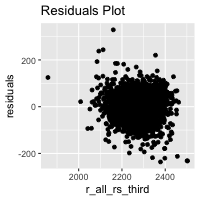

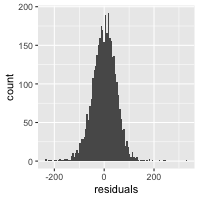

In [45]:
%%R -h 200 -w 200

print(
    ggplot(to_plot) +
        aes(x=r_all_rs_third, y=residuals) +
        geom_point() +
        ggtitle("Residuals Plot"))

ggplot(to_plot) +
    aes(x=residuals) +
    geom_histogram(bins=100) 


🤔 Hmmm...the residuals seem to be normally distributed...but what are these seemingly gigantic outliers? How do we know if they're suspicious? How many datapoints do we have as a whole and number of values would we expect to see above 3 stdevs > the mean?

# Finding suspicious datapoints with linear regression

Is Harrell Budd Elementary's fourth grade reading classrooms the only place where we see suspicious scores in 2004? 

How else can you design regressions to help you uncover other instances of cheating? 

In the cells below, try to define your own questions and see if you can uncover other suspicious scores using regressions. You may also want to use plots as necessary. You can start with reading (`r_all_rs`) and math (`m_all_rs`) scores in the data we have loaded, but if you'd like, you're also welcome to bring in other variables from the [data documentation](
https://tea.texas.gov/sites/default/files/TAKS-Variables-prior2005.pdf).

- If you've got an interesting finding, put up a green sticky note! 🟩

- If you're stuck, put up a red sticky note! 🟥

## Load the data again
This time I'm also adding fourth grade scores from last year (2003), which you decided to download after digging around the 2004 scores. 


In [84]:
df_third_grade_2004 = pd.read_csv("data/cfy04e3.dat", usecols=['r_all_rs', 'm_all_rs', 'CNAME', 'CAMPUS']).set_index('CAMPUS').add_suffix('_third')
df_fourth_grade_2004 = pd.read_csv("data/cfy04e4.dat", usecols=['r_all_rs', 'm_all_rs', 'CNAME', 'CAMPUS']).set_index('CAMPUS').add_suffix('_fourth')
df_fifth_grade_2004 = pd.read_csv("data/cfy04e5.dat", usecols=['r_all_rs', 'm_all_rs', 'CNAME', 'CAMPUS']).set_index('CAMPUS').add_suffix('_fifth')

# This time I'm also adding fourth grade scores from last year (2003)! 
df_fourth_grade_2003 = pd.read_csv("data/cfy04e3.dat", usecols=['r_all_rs', 'm_all_rs', 'CNAME', 'CAMPUS']).set_index('CAMPUS').add_suffix('_fourth_last_year')

# Combine the above dataframes, remove duplicate columns
df = pd.concat([df_third_grade_2004, df_fourth_grade_2004, df_fifth_grade_2004, df_fourth_grade_2003], axis=1)
df['CNAME'] = df['CNAME_third'].fillna(df['CNAME_fourth']).fillna(df['CNAME_fifth']).fillna(df['CNAME_fourth_last_year'])
df = df.drop(columns=['CNAME_third', 'CNAME_fourth', 'CNAME_fifth', 'CNAME_fourth_last_year'])
df = df.reset_index()

# display
df


,CAMPUS,r_all_rs_third,m_all_rs_third,r_all_rs_fourth,m_all_rs_fourth,r_all_rs_fifth,m_all_rs_fifth,r_all_rs_fourth_last_year,m_all_rs_fourth_last_year,CNAME
0,1902103,2410.0,2388.0,2392.0,2227.0,2308.0,2317.0,2410.0,2388.0,CAYUGA EL
1,1903101,2256.0,2208.0,2263.0,2192.0,2193.0,2153.0,2256.0,2208.0,ELKHART EL
2,1904102,2284.0,2313.0,2242.0,2152.0,2288.0,2256.0,2284.0,2313.0,FRANKSTON EL
3,1906102,2294.0,2273.0,2218.0,2096.0,2298.0,2312.0,2294.0,2273.0,NECHES EL
4,1907110,2256.0,2205.0,2200.0,2168.0,2218.0,2269.0,2256.0,2205.0,STORY EL
...,...,...,...,...,...,...,...,...,...,...
4232,241904041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WHARTON J H
4233,243902041,NaN,NaN,NaN,NaN,2117.0,2129.0,NaN,NaN,ELECTRA J H
4234,249905102,NaN,NaN,NaN,NaN,2238.0,2255.0,NaN,NaN,DECATUR INT
4235,250907041,NaN,NaN,NaN,NaN,2231.0,2241.0,NaN,NaN,MEMORIAL MIDDLE


In [ ]:
# This is your scratchpad, use this to explore the data!

# Bonus 🤖 (very optional)

This loads a giant dataframe with all of the columns from 2004 (there are 2827 columns 😲). 

Here is the documentation for those columns:
https://tea.texas.gov/sites/default/files/TAKS-Variables-prior2005.pdf

How would you use the additional data? What variables will you target first? Design more statstical inquiry that takes advantage of the full dataset.

In [ ]:
df_third_grade_2004 = pd.read_csv("data/cfy04e3.dat").set_index('CAMPUS').assign(grade='third')
df_fourth_grade_2004 = pd.read_csv("data/cfy04e4.dat").set_index('CAMPUS').assign(grade='fourth')
df_fifth_grade_2004 = pd.read_csv("data/cfy04e5.dat").set_index('CAMPUS').assign(grade='fifth')

df_2004 = pd.concat([df_third_grade_2004, df_fourth_grade_2004, df_fifth_grade_2004])
df_2004